# **Primitives**

**Primitive**: The smallest processing instruction for a given abstraction level.

The simplest building block you can give a user to create something useful.

From the user's perspective are black boxes that do something you need but don't care the specific implementation details.

**Estimator Primitive:** Computes expectation values of observables with the respective states prepared by quantum circuits.

**Sampler Primitive:** Ruturns shot by shot bit strings sampled from the probability distribution of the quantum state prepared on the device.

# Transverse field Ising model to demo primitives

In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit.library import YGate, UnitaryGate

SYGate = UnitaryGate(YGate().power(1/2), label=r"$\sqrt{Y}$")
SYdgGate = UnitaryGate(SYGate.inverse(), label=r"$\sqrt{Y}^\dag$")

In [2]:
def generate_1d_tfim_circuit(num_qubits, num_trotter_steps, rx_angle, num_cl_bits=0, trotter_barriers = False, layer_barriers = False):
    if num_cl_bits == 0:
        qc = QuantumCircuit(num_qubits)
    else:
        qc = QuantumCircuit(num_qubits, num_cl_bits)

    for trotter_step in range(num_trotter_steps):
        add_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers)
        if trotter_barriers:
            qc.barrier()

    return qc

def add_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers):
    # Adding Rzz in the even layers
    for i in range(0, qc.num_qubits - 1, 2):
        qc.sdg([i, i+1])
        qc.append(SYGate, [i+1])
        qc.cx(i, i+1)
        qc.append(SYdgGate, [i+1])
    if layer_barriers:
        qc.barrier()

    # Adding Rzz in the odd layers
    for i in range(1, qc.num_qubits - 1, 2):
        qc.sdg([i, i+1])
        qc.append(SYGate, [i+1])
        qc.cx(i, i+1)
        qc.append(SYdgGate, [i+1])
    if layer_barriers:
        qc.barrier()

    qc.rx(rx_angle, list(range(qc.num_qubits)))
    if layer_barriers:
        qc.barrier()

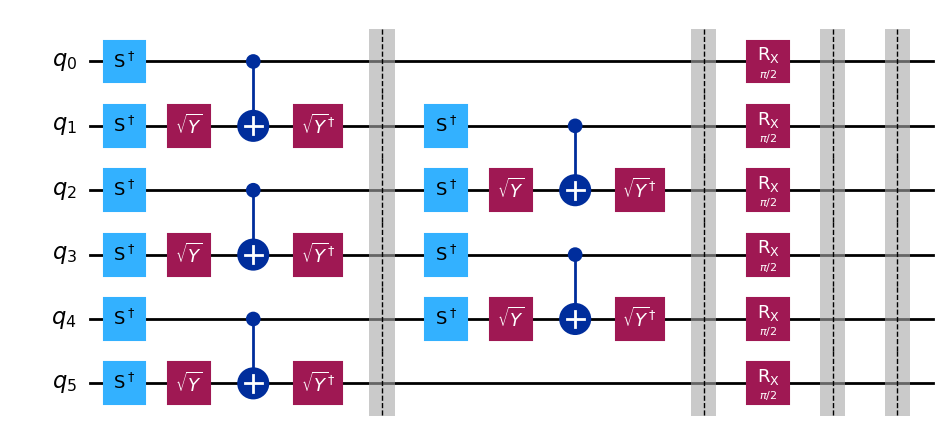

In [3]:
num_qubits = 6
num_trotter_steps = 1
rx_angle = 0.5 * np.pi

qc = generate_1d_tfim_circuit(num_qubits, num_trotter_steps, rx_angle, trotter_barriers=True, layer_barriers=True)
qc.draw(output="mpl", fold=1)

# Demo: Sampler

In [4]:
def append_mirrored_1d_tfim_circuit(qc, num_qubits, num_trotter_steps, rx_angle, trotter_barriers = False, layer_barriers = False):

    for trotter_step in range(num_trotter_steps):
        add_mirrored_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers)
        if trotter_barriers:
            qc.barrier()

def add_mirrored_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers):
    qc.rx(-rx_angle, list(range(qc.num_qubits)))
    if layer_barriers:
        qc.barrier()

    # Adding Rzz in the odd layers
    for i in range(1, qc.num_qubits - 1, 2):
        qc.append(SYGate, [i+1])
        qc.cx(i, i+1)
        qc.append(SYdgGate, [i+1])
        qc.s([i, i+1])
    if layer_barriers:
        qc.barrier()

    # Adding Rzz in the even layers
    for i in range(0, qc.num_qubits - 1, 2):
        qc.append(SYGate, [i+1])
        qc.cx(i, i+1)
        qc.append(SYdgGate, [i+1])
        qc.s([i, i+1])
    if layer_barriers:
        qc.barrier()

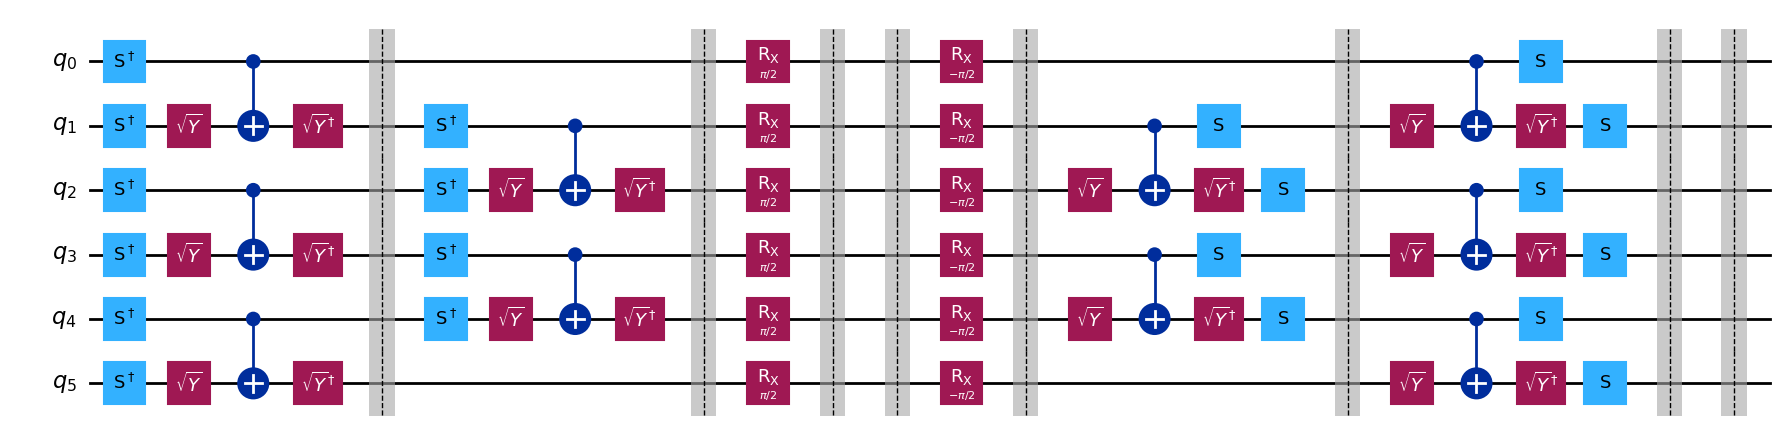

In [5]:
qc_mirrored = append_mirrored_1d_tfim_circuit(qc, num_qubits, num_trotter_steps, rx_angle, trotter_barriers=True, layer_barriers=True)
qc.draw(output="mpl", fold=-1)

# Step 1: Map the problem to circuits and observables

In [6]:
max_trotter_steps = 10
num_qubits = 100

measured_qubits = [49, 50]

qc_list = []
for trotter_step in range(max_trotter_steps):
    qc = generate_1d_tfim_circuit(num_qubits, trotter_step, rx_angle,num_cl_bits=len(measured_qubits), trotter_barriers=True, layer_barriers=True)
    append_mirrored_1d_tfim_circuit(qc, num_qubits, trotter_step, rx_angle, trotter_barriers=True, layer_barriers=True)
    qc.measure(measured_qubits, list(range(len(measured_qubits))))
    qc_list.append(qc)


# Step 2: Optimize

In [7]:
from qiskit import transpile
from qiskit_ibm_runtime import QiskitRuntimeService

backend_name = "ibm_torino"
service = QiskitRuntimeService()
backend = service.backend(backend_name)

qc_transpiled_list = transpile(qc_list, backend=backend, optimization_level=1)

qiskit_runtime_service._resolve_cloud_instances:WARNING:2025-07-06 18:46:49,008: Default instance not set. Searching all available instances.


# Step 3: Execute on hardware

In [8]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime.options.sampler_options import SamplerOptions

sampler = Sampler(backend)
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"

job = sampler.run(qc_transpiled_list)
print(job.job_id())


d1lah0v29o4s73aphj3g


# Step 4: Post-processing and plotting

In [9]:
survival_probability_list = []
for trotter_step in range(max_trotter_steps):
    try:
        data = job.result()[trotter_step].data
        survival_probability_list.append(data.c.get_counts()["0" * len(measured_qubits)]/data.c.num_shots)
    except:
        survival_probability_list.append(0)

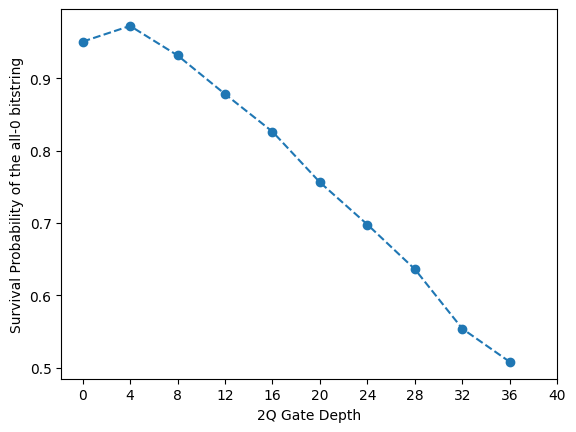

In [10]:
import matplotlib.pyplot as plt

plt.plot(list(range(0, 4 * max_trotter_steps, 4)), survival_probability_list, "--o")
plt.xlabel("2Q Gate Depth")
plt.ylabel("Survival Probability of the all-0 bitstring")
plt.xticks(np.arange(0, 44, 4))
plt.show()

# Estimator

In [12]:
from qiskit.circuit import Parameter

rx_angle = Parameter("rx_angle")
trotter_step = 2
qc = generate_1d_tfim_circuit(num_qubits, trotter_step, rx_angle)

from qiskit.quantum_info import SparsePauliOp

middle_index = num_qubits // 2

observale = SparsePauliOp("I" * middle_index + "Z" + "I" * (middle_index-1))

# Step 2: Optimize

In [14]:
from qiskit import transpile
from qiskit_ibm_runtime import QiskitRuntimeService

backend_name = "ibm_torino"
service = QiskitRuntimeService()
backend = service.backend(backend_name)

qc_transpiled = transpile(qc, backend=backend, optimization_level=1)
observale = observale.apply_layout(qc_transpiled.layout)

qiskit_runtime_service._resolve_cloud_instances:WARNING:2025-07-06 18:54:43,137: Default instance not set. Searching all available instances.


# Step 3: Execute on hardware

In [16]:
from qiskit_ibm_runtime import EstimatorV2, EstimatorOptions

min_rx_angle = 0
max_rx_angle = np.pi/2

num_rx_angle = 12
rx_angle_list = np.linspace(min_rx_angle, max_rx_angle, num_rx_angle)

options = EstimatorOptions()
options.resilience_level = 1
options.dynamical_decoupling.enable = True
options.dynamical_decoupling.sequence_type = "XY4"

estimator = EstimatorV2(backend, options=options)

job = estimator.run([(qc_transpiled, observale, rx_angle_list)])

# Step 4: Post-processing and plotting

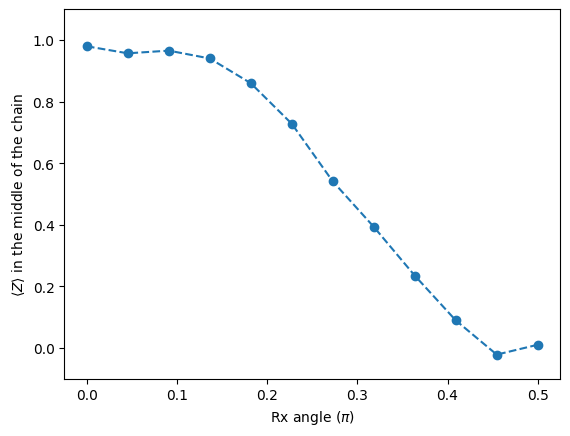

In [19]:
exp_val_list = job.result()[0].data.evs

plt.plot(rx_angle_list / np.pi, exp_val_list, "--o")
plt.xlabel(r"Rx angle ($\pi$)")
plt.ylabel(r"$\langle Z \rangle$ in the middle of the chain")
plt.ylim(-0.1, 1.1)
plt.show()